# Instructions

### This notebook was designed to do statistical analysis for data from VBL experiments.




 

## Import packages and read the dataset

In [ ]:
import pandas as pd
import numpy as np

# Enable interactive Matplotlib plots in the notebook
# %matplotlib qt5

import matplotlib.pyplot as plt
from matplotlib import cm
import os
# import astropy.convolution as krn
import scipy.stats as stats
from scipy.stats import ttest_ind
import sys
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import seaborn as sns


# Read the dataset
# path_to_dataset = 'C:/Users/artem/Dropbox/DeepEye_Pilots/VBL_Exp1/data/approved/analysis/allSubjects_VBLExp1.csv'
path_to_dataset = 'D:/Dropbox/DeepEye_Pilots/VBL_Exp1/data/approved/analysis/allSubjects_VBLExp1.csv'
df = pd.read_csv(path_to_dataset)



### Filter data

In [ ]:
# # filter out excluded participants if needed
# # output_df = output_df[~output_df['deepeye-id'].isin(['2024_01_15_14_19_20', '2024_01_26_17_16_28'])]

# Create one code for Model Size, independent of the dress type
df['AOI_stim_adj'] = df['AOI_stim'].apply(lambda x: '_'.join(x.split('_')[:2]) if x.startswith('Model') else x)

# Select only Dresses
df = df[df.AOI_stim_adj.str.contains('Model')]


### Fixation Durations (Proportion of fixation duration on on each stimulus)

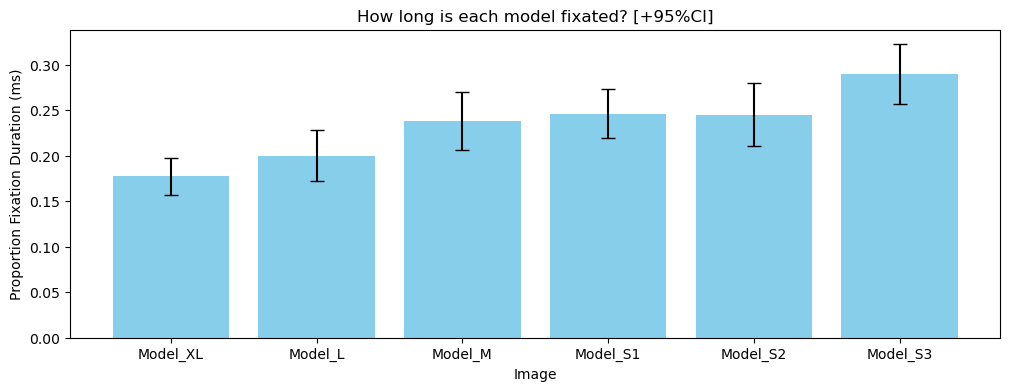

T-statistic: -5.537411831293045, P-value: 7.190067141209022e-08
197


In [36]:
# group data
fixDur = df.groupby(['pp_id', 'AOI_stim_adj']).FixDur.sum()
fixDur_df = fixDur.reset_index()

# Calculate 'FixDurProp'
fixDur_df['FixDurProp'] = fixDur_df.groupby('pp_id')['FixDur'].transform(lambda x: x / x.sum())

# Calculate mean and standard error of the mean (SEM)
stats = fixDur_df.groupby('AOI_stim_adj').agg(
    mean=('FixDurProp', 'mean'),
    ci_95=('FixDurProp', lambda x: 1.96 * np.std(x, ddof=1) / np.sqrt(len(x)))
)

# Extracting values for plotting
categories = stats.index.tolist()
means = stats['mean'].tolist()
errors = stats['ci_95'].tolist()

# Custom order
order = {'Model_XL': 0, 'Model_L': 1, 'Model_M': 2, 'Model_S1': 3, 'Model_S2': 4, 'Model_S3': 5}

# Sort according to custom order
sorted_categories = sorted(zip(categories, means, errors), key=lambda x: order[x[0]])
categories, means, errors = zip(*sorted_categories)

# Creating the bar graph with error bars
plt.figure(figsize=(12, 4))
plt.bar(categories, means, color='skyblue', yerr=errors, capsize=5)
# plt.ylim([800, 1800])

# Adding titles and labels
plt.title('How long is each model fixated? [+95%CI]')
plt.xlabel('Image')
plt.ylabel('Proportion Fixation Duration (ms)')

# Show the plot
plt.show()


# Some stats
modelL = fixDur_df[fixDur_df.AOI_stim_adj == 'Model_L'].FixDurProp
modelS1 = fixDur_df[fixDur_df.AOI_stim_adj == 'Model_S1'].FixDurProp
modelS2 = fixDur_df[fixDur_df.AOI_stim_adj == 'Model_S2'].FixDurProp
modelS3 = fixDur_df[fixDur_df.AOI_stim_adj == 'Model_S3'].FixDurProp
modelXL = fixDur_df[fixDur_df.AOI_stim_adj == 'Model_XL'].FixDurProp
modelM = fixDur_df[fixDur_df.AOI_stim_adj == 'Model_M'].FixDurProp

t_stat, p_value = ttest_ind(modelXL, modelS3)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

print(fixDur_df.pp_id.unique().size)

### Fixation Latency

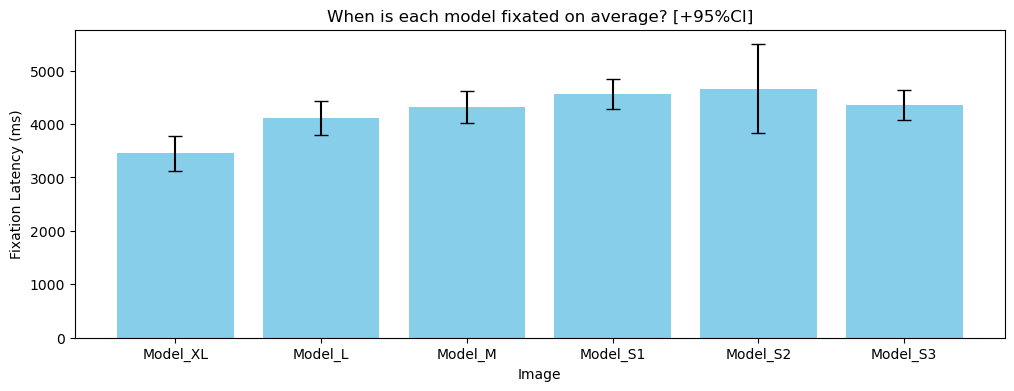

In [37]:
# group data
fixLatency = df.groupby(['pp_id', 'AOI_stim_adj']).FixLatency.mean()
fixLatency_df = fixLatency.reset_index()

# Calculate mean and standard error of the mean (SEM)
stats = fixLatency_df.groupby('AOI_stim_adj').agg(
    mean=('FixLatency', 'mean'),
    ci_95=('FixLatency', lambda x: 1.96 * np.std(x, ddof=1) / np.sqrt(len(x)))
)

# Extracting values for plotting
categories = stats.index.tolist()
means = stats['mean'].tolist()
errors = stats['ci_95'].tolist()

# Custom order
order = {'Model_XL': 0, 'Model_L': 1, 'Model_M': 2, 'Model_S1': 3, 'Model_S2': 4, 'Model_S3': 5}

# Sort according to custom order
sorted_categories = sorted(zip(categories, means, errors), key=lambda x: order[x[0]])
categories, means, errors = zip(*sorted_categories)

# Creating the bar graph with error bars
plt.figure(figsize=(12, 4))
plt.bar(categories, means, color='skyblue', yerr=errors, capsize=5)

# Adding titles and labels
plt.title('When is each model fixated on average? [+95%CI]')
plt.xlabel('Image')
plt.ylabel('Fixation Latency (ms)')

# Show the plot
plt.show()

### Plot Distribution of Fixation Latencies

count of datapoints in Model_L: 140
count of datapoints in Model_M: 145
count of datapoints in Model_S1: 145
count of datapoints in Model_S2: 138
count of datapoints in Model_S3: 144
count of datapoints in Model_XL: 132


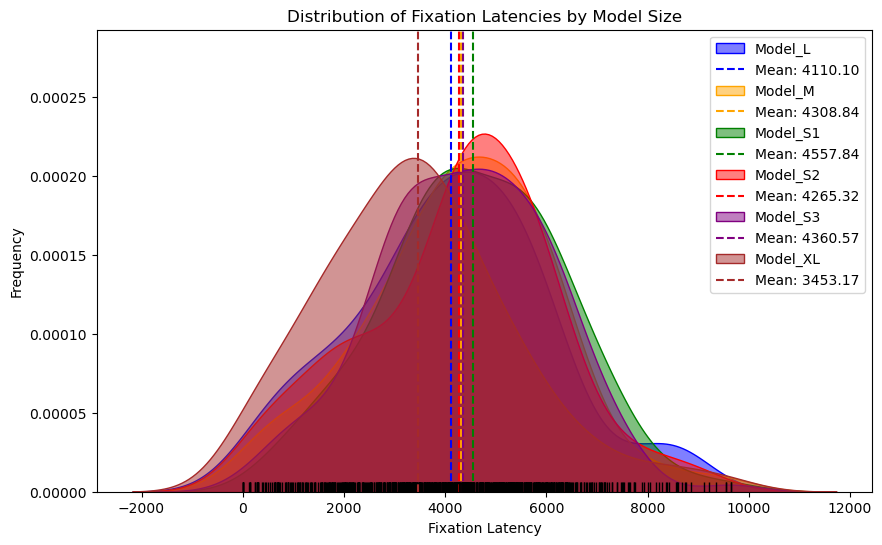

T-statistic: -2.591978960654336, P-value: 0.010065970951541013


In [41]:
# Plot distributions of latencies

# Set up the plot dimensions and style
plt.figure(figsize=(10, 6))

# Get unique groups
groups = fixLatency_df['AOI_stim_adj'].unique()

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# Plot histogram for each group
for i, group in enumerate(groups):
    color = colors[i]
    # Extract the data for the group
    group_data = fixLatency_df[fixLatency_df['AOI_stim_adj'] == group]['FixLatency']
    print(f'count of datapoints in {group}: {group_data.count()}')
    group_data = group_data[group_data < 10000]
    
    # Plot the kde
    sns.kdeplot(data=group_data, fill=True, color=color, alpha=0.5, label=group)
    
    # Plot individual points
    sns.rugplot(data=group_data, height=0.02, color="k")
    
    # Plot the mean vertical line
    mean_data = group_data.mean()
    plt.axvline(mean_data, color=color, linestyle='--', linewidth=1.5, label=f'Mean: {mean_data:.2f}')

# Add legend, title, and labels
plt.legend()
plt.title('Distribution of Fixation Latencies by Model Size')
plt.xlabel('Fixation Latency')
plt.ylabel('Frequency')

plt.show()


# Some stats
modelS2 = fixLatency_df[fixLatency_df.AOI_stim_adj == 'Model_S2'].FixLatency
modelXL = fixLatency_df[fixLatency_df.AOI_stim_adj == 'Model_XL'].FixLatency

t_stat, p_value = ttest_ind(modelXL, modelS2)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

### Fixation Order (average order of fixations for each model)


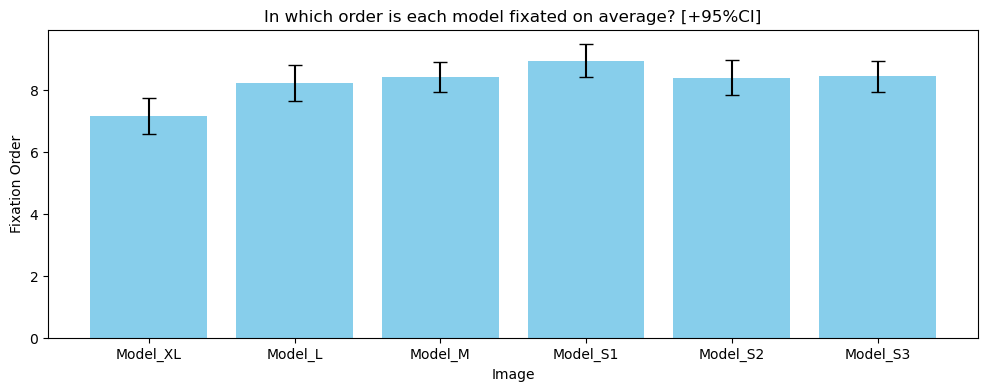

In [40]:
# group data
fixOrder = df.groupby(['pp_id', 'AOI_stim_adj']).FixationOrder.mean()
fixOrder_df = fixOrder.reset_index()

# Calculate mean and standard error of the mean (SEM)
stats = fixOrder_df.groupby('AOI_stim_adj').agg(
    mean=('FixationOrder', 'mean'),
    ci_95=('FixationOrder', lambda x: 1.96 * np.std(x, ddof=1) / np.sqrt(len(x)))
)

# Extracting values for plotting
categories = stats.index.tolist()
means = stats['mean'].tolist()
errors = stats['ci_95'].tolist()

# Custom order
order = {'Model_XL': 0, 'Model_L': 1, 'Model_M': 2, 'Model_S1': 3, 'Model_S2': 4, 'Model_S3': 5}

# Sort according to custom order
sorted_categories = sorted(zip(categories, means, errors), key=lambda x: order[x[0]])
categories, means, errors = zip(*sorted_categories)


# Creating the bar graph with error bars
plt.figure(figsize=(12, 4))
plt.bar(categories, means, color='skyblue', yerr=errors, capsize=5)
# plt.ylim([800, 1800])

# Adding titles and labels
plt.title('In which order is each model fixated on average? [+95%CI]')
plt.xlabel('Image')
plt.ylabel('Fixation Order')

# Show the plot
plt.show()

### Fixation Count

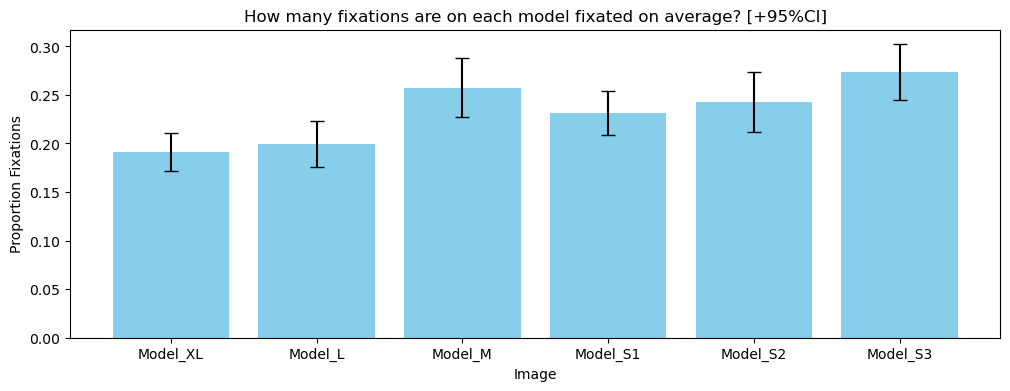

T-statistic: -4.597517187688127, P-value: 6.5354047461221966e-06


In [39]:
# group data
fixCount = df.groupby(['pp_id', 'AOI_stim_adj']).FixDur.count()
fixCount_df = fixCount.reset_index()
fixCount_df = fixCount_df.rename(columns={'FixDur': 'FixCount'})

# Calculate 'FixCountProp'
fixCount_df['FixCountProp'] = fixCount_df.groupby('pp_id')['FixCount'].transform(lambda x: x / x.sum())

# Calculate mean and standard error of the mean (SEM)
stats = fixCount_df.groupby('AOI_stim_adj').agg(
    mean=('FixCountProp', 'mean'),
    ci_95=('FixCountProp', lambda x: 1.96 * np.std(x, ddof=1) / np.sqrt(len(x)))
)

# Extracting values for plotting
categories = stats.index.tolist()
means = stats['mean'].tolist()
errors = stats['ci_95'].tolist()

# Custom order
order = {'Model_XL': 0, 'Model_L': 1, 'Model_M': 2, 'Model_S1': 3, 'Model_S2': 4, 'Model_S3': 5}

# Sort according to custom order
sorted_categories = sorted(zip(categories, means, errors), key=lambda x: order[x[0]])
categories, means, errors = zip(*sorted_categories)

# Creating the bar graph with error bars
plt.figure(figsize=(12, 4))
plt.bar(categories, means, color='skyblue', yerr=errors, capsize=5)

# Adding titles and labels
plt.title('How many fixations are on each model fixated on average? [+95%CI]')
plt.xlabel('Image')
plt.ylabel('Proportion Fixations')

# Show the plot
plt.show()

# Some stats
modelL = fixCount_df[fixCount_df.AOI_stim_adj == 'Model_L'].FixCountProp
modelS1 = fixCount_df[fixCount_df.AOI_stim_adj == 'Model_S1'].FixCountProp
modelS2 = fixCount_df[fixCount_df.AOI_stim_adj == 'Model_S2'].FixCountProp
modelS3 = fixCount_df[fixCount_df.AOI_stim_adj == 'Model_S3'].FixCountProp
modelXL = fixCount_df[fixCount_df.AOI_stim_adj == 'Model_XL'].FixCountProp
modelM = fixCount_df[fixCount_df.AOI_stim_adj == 'Model_M'].FixCountProp

t_stat, p_value = ttest_ind(modelXL, modelS3)
print(f"T-statistic: {t_stat}, P-value: {p_value}")